In [20]:
import numpy as np
import mxnet as mx
import time
import pandas as pd

import cv2

import logging
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
data0 = pd.read_csv('full_hand_data.csv')#, names=['name','state'])

In [23]:
data0.head()

,name,state
0,data/fdata1/hand_pic/a_232bf02f_0_lc.jpg,0
1,data/fdata1/hand_pic/a_232bf02f_1_lo.jpg,1
2,data/fdata1/hand_pic/a_232bf02f_2_lq.jpg,2
3,data/fdata1/hand_pic/a_232bf02f_3_lw.jpg,3
4,data/fdata1/hand_pic/a_232bf02f_4_le.jpg,4


In [24]:
num_class = len(data0['state'].unique())

In [25]:
import json
with open('num2ges.json') as fin:
    num_to_ges = json.load(fin, encoding='latin')
num_to_ges

{u'0': u' lc',
 u'1': u' lo',
 u'10': u' mc',
 u'11': u' mo',
 u'12': u' mq',
 u'13': u' mw',
 u'14': u' me',
 u'15': u' m1',
 u'16': u' m2',
 u'17': u' m3',
 u'18': u' m4',
 u'19': u' m5',
 u'2': u' lq',
 u'20': u' rc',
 u'21': u' ro',
 u'22': u' rq',
 u'23': u' rw',
 u'24': u' re',
 u'25': u' r1',
 u'26': u' r2',
 u'27': u' r3',
 u'28': u' r4',
 u'29': u' r5',
 u'3': u' lw',
 u'30': u'vc',
 u'31': u'vo',
 u'32': u'vq',
 u'33': u'vw',
 u'34': u've',
 u'35': u'v1',
 u'36': u'v2',
 u'37': u'v3',
 u'38': u'v4',
 u'39': u'v5',
 u'4': u' le',
 u'5': u' l1',
 u'6': u' l2',
 u'7': u' l3',
 u'8': u' l4',
 u'9': u' l5'}

In [26]:
# data0 = data0.replace({'state':ges_to_num})

In [27]:
data0.shape

(4320, 2)

In [28]:
import os

models_path = 'models'
if not os.path.exists(models_path):
    os.makedirs(models_path)

labels = np.empty((data0.shape[0]))

# res_width, res_height = 200, 200
res_width, res_height = 64, 64

imgs = np.empty(shape=(data0.shape[0],3, res_width,res_height))
imgs.shape, labels.shape

((4320, 3, 64, 64), (4320,))

In [29]:

for i, (im_path, state) in enumerate(data0.values):
#     im_path = prefix + im_name
#     print im_path
    img = cv2.imread(im_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    res = cv2.resize(gray,(res_width, res_height), interpolation=cv2.INTER_CUBIC)

    res = np.swapaxes(res, 0, 2)
    res = np.swapaxes(res, 1, 2)
    res = res[np.newaxis, :]

    imgs[i] = res
    labels[i] = state

In [30]:
# plt.imshow(gray)

In [31]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_label, test_label = train_test_split(imgs, labels, test_size=0.1, shuffle=True)

In [32]:
# train_data, train_label = imgs, labels
# test_data, test_label = imgs[23:], labels[2:]
train_data.shape, train_label.shape, test_data.shape, test_label.shape

((3888, 3, 64, 64), (3888,), (432, 3, 64, 64), (432,))

In [33]:
test_label

array([  5.,  30.,  34.,  24.,  13.,  14.,  34.,   6.,  38.,  33.,   5.,
        11.,  38.,  19.,  28.,  30.,  33.,  31.,  14.,  38.,   2.,  36.,
        23.,  15.,  38.,  33.,  27.,  37.,  31.,  30.,   9.,  33.,  31.,
        21.,   3.,   2.,  36.,  39.,  38.,   9.,  33.,   4.,  39.,  18.,
        33.,   4.,  32.,  36.,  31.,  31.,  28.,  25.,  30.,  36.,   9.,
        30.,  21.,  30.,   5.,  34.,  38.,  35.,   7.,  36.,  25.,  35.,
        31.,   9.,   4.,  27.,  10.,  34.,   5.,  18.,  14.,   2.,  33.,
        37.,  38.,  37.,  11.,  32.,  37.,  34.,   1.,  32.,  38.,  30.,
        32.,  26.,  36.,  24.,  25.,  35.,  28.,  30.,   4.,   2.,   4.,
        14.,  36.,  33.,  24.,  38.,  37.,  30.,  38.,  39.,  39.,  29.,
        21.,   0.,  37.,  35.,   2.,  14.,  32.,  10.,   9.,  31.,  20.,
        22.,  32.,   1.,  37.,  30.,  14.,  12.,  16.,  31.,  35.,   4.,
        15.,   1.,  36.,   4.,  37.,  26.,  20.,  36.,  22.,  24.,  12.,
        23.,  10.,  30.,  34.,  28.,  33.,  24.,  2

In [34]:
batch_size = 128
train_iter = mx.io.NDArrayIter(train_data, train_label, batch_size, shuffle=True)
eval_iter = mx.io.NDArrayIter(test_data, test_label, batch_size)

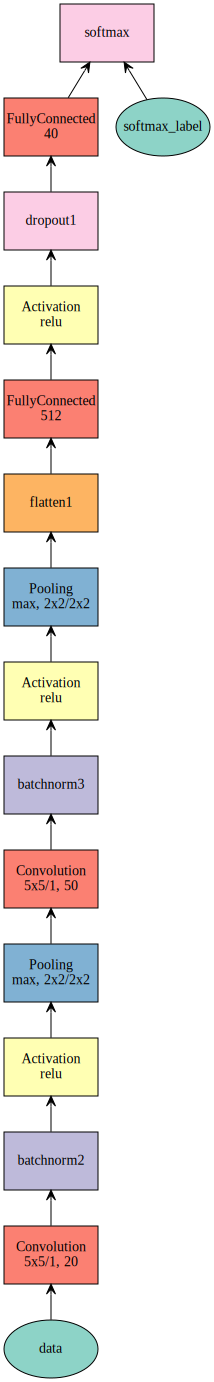

In [35]:
data = mx.sym.var('data')

conv1 = mx.sym.Convolution(data=data, kernel=(5,5), num_filter=20, name='conv1')
bn1 = mx.sym.BatchNorm(conv1, fix_gamma=True)
tanh1 = mx.sym.Activation(data=bn1, act_type='relu')
pool1 = mx.sym.Pooling(data=tanh1, pool_type='max', kernel=(2,2), stride=(2,2))

conv2 = mx.sym.Convolution(data=pool1, kernel=(5,5), num_filter=50, name='conv2')
bn2 = mx.sym.BatchNorm(conv2, fix_gamma=True)
tanh2 = mx.sym.Activation(data=bn2, act_type='relu')
pool2 = mx.sym.Pooling(data=tanh2, pool_type='max', kernel=(2,2), stride=(2,2))

flat = mx.sym.flatten(data=pool2)
fc1 = mx.sym.FullyConnected(data=flat, num_hidden=512)
tanh3 = mx.sym.Activation(data=fc1, act_type='relu')

drop = mx.symbol.Dropout(tanh3, p=0.5)
fc2 = mx.sym.FullyConnected(data=drop, num_hidden=num_class)

convnet = mx.sym.SoftmaxOutput(data=fc2, name='softmax')

mx.viz.plot_network(convnet)

In [36]:
model = mx.mod.Module(symbol=convnet, context=mx.gpu())

In [37]:
model.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
model.init_params(initializer=mx.init.Uniform(scale=.01))
model.init_optimizer(optimizer='sgd', optimizer_params={'learning_rate':0.001, 'wd': 0.001})

metric = mx.metric.Accuracy()

In [38]:
chk_prefix='models/chkpt'
for epoch in range(400):
    train_iter.reset()
    metric.reset()
    
    st = time.time()
    for batch in train_iter:
        model.forward(data_batch=batch, is_train=True)
        model.update_metric(metric, batch.label)
        model.backward()
        model.update()
    
    if epoch % 30 == 0:
#         model_path = '{}_{}'.format(chk_prefix, epoch)
        model.save_checkpoint(chk_prefix, epoch)
        
    et = time.time()-st
    print('Epoch %d, Training %s, Time %.2f' % (epoch, metric.get(), et))

INFO:root:Saved checkpoint to "models/chkpt-0000.params"


Epoch 0, Training ('accuracy', 0.04813508064516129), Time 1.24
Epoch 1, Training ('accuracy', 0.06703629032258064), Time 1.18
Epoch 2, Training ('accuracy', 0.07888104838709678), Time 1.16
Epoch 3, Training ('accuracy', 0.08366935483870967), Time 1.09
Epoch 4, Training ('accuracy', 0.08190524193548387), Time 1.13
Epoch 5, Training ('accuracy', 0.0924899193548387), Time 1.10
Epoch 6, Training ('accuracy', 0.08870967741935484), Time 1.09
Epoch 7, Training ('accuracy', 0.09400201612903226), Time 1.09
Epoch 8, Training ('accuracy', 0.09954637096774194), Time 1.09
Epoch 9, Training ('accuracy', 0.10786290322580645), Time 1.15
Epoch 10, Training ('accuracy', 0.11668346774193548), Time 1.13
Epoch 11, Training ('accuracy', 0.1280241935483871), Time 1.18
Epoch 12, Training ('accuracy', 0.12701612903225806), Time 1.13
Epoch 13, Training ('accuracy', 0.1509576612903226), Time 1.09
Epoch 14, Training ('accuracy', 0.1484375), Time 1.20
Epoch 15, Training ('accuracy', 0.1665826612903226), Time 1.20


INFO:root:Saved checkpoint to "models/chkpt-0030.params"


Epoch 30, Training ('accuracy', 0.4180947580645161), Time 1.19
Epoch 31, Training ('accuracy', 0.4415322580645161), Time 1.08
Epoch 32, Training ('accuracy', 0.4710181451612903), Time 1.19
Epoch 33, Training ('accuracy', 0.4808467741935484), Time 1.10
Epoch 34, Training ('accuracy', 0.49243951612903225), Time 1.11
Epoch 35, Training ('accuracy', 0.5279737903225806), Time 1.09
Epoch 36, Training ('accuracy', 0.5254536290322581), Time 1.13
Epoch 37, Training ('accuracy', 0.5433467741935484), Time 1.15
Epoch 38, Training ('accuracy', 0.5622479838709677), Time 1.10
Epoch 39, Training ('accuracy', 0.5758568548387096), Time 1.09
Epoch 40, Training ('accuracy', 0.5776209677419355), Time 1.08
Epoch 41, Training ('accuracy', 0.5914818548387096), Time 1.09
Epoch 42, Training ('accuracy', 0.6199596774193549), Time 1.09
Epoch 43, Training ('accuracy', 0.6197076612903226), Time 1.09
Epoch 44, Training ('accuracy', 0.6411290322580645), Time 1.09
Epoch 45, Training ('accuracy', 0.6403729838709677), T

INFO:root:Saved checkpoint to "models/chkpt-0060.params"


Epoch 60, Training ('accuracy', 0.7731854838709677), Time 1.21
Epoch 61, Training ('accuracy', 0.7764616935483871), Time 1.07
Epoch 62, Training ('accuracy', 0.7852822580645161), Time 1.11
Epoch 63, Training ('accuracy', 0.8067036290322581), Time 1.11
Epoch 64, Training ('accuracy', 0.8039314516129032), Time 1.10
Epoch 65, Training ('accuracy', 0.8054435483870968), Time 1.10
Epoch 66, Training ('accuracy', 0.8145161290322581), Time 1.09
Epoch 67, Training ('accuracy', 0.8248487903225806), Time 1.13
Epoch 68, Training ('accuracy', 0.8288810483870968), Time 1.10
Epoch 69, Training ('accuracy', 0.8361895161290323), Time 1.09
Epoch 70, Training ('accuracy', 0.8296370967741935), Time 1.10
Epoch 71, Training ('accuracy', 0.8382056451612904), Time 1.11
Epoch 72, Training ('accuracy', 0.842741935483871), Time 1.14
Epoch 73, Training ('accuracy', 0.8576108870967742), Time 1.12
Epoch 74, Training ('accuracy', 0.8508064516129032), Time 1.17
Epoch 75, Training ('accuracy', 0.850554435483871), Time

INFO:root:Saved checkpoint to "models/chkpt-0090.params"


Epoch 90, Training ('accuracy', 0.8969254032258065), Time 1.16
Epoch 91, Training ('accuracy', 0.8984375), Time 1.15
Epoch 92, Training ('accuracy', 0.9007056451612904), Time 1.11
Epoch 93, Training ('accuracy', 0.9070060483870968), Time 1.13
Epoch 94, Training ('accuracy', 0.9082661290322581), Time 1.15
Epoch 95, Training ('accuracy', 0.907258064516129), Time 1.13
Epoch 96, Training ('accuracy', 0.9042338709677419), Time 1.15
Epoch 97, Training ('accuracy', 0.9077620967741935), Time 1.09
Epoch 98, Training ('accuracy', 0.9185987903225806), Time 1.09
Epoch 99, Training ('accuracy', 0.9112903225806451), Time 1.10
Epoch 100, Training ('accuracy', 0.9115423387096774), Time 1.09
Epoch 101, Training ('accuracy', 0.9238911290322581), Time 1.09
Epoch 102, Training ('accuracy', 0.9180947580645161), Time 1.09
Epoch 103, Training ('accuracy', 0.9213709677419355), Time 1.11
Epoch 104, Training ('accuracy', 0.9168346774193549), Time 1.09
Epoch 105, Training ('accuracy', 0.9213709677419355), Time 1

INFO:root:Saved checkpoint to "models/chkpt-0120.params"


Epoch 120, Training ('accuracy', 0.9397681451612904), Time 1.21
Epoch 121, Training ('accuracy', 0.9402721774193549), Time 1.09
Epoch 122, Training ('accuracy', 0.9400201612903226), Time 1.09
Epoch 123, Training ('accuracy', 0.9435483870967742), Time 1.09
Epoch 124, Training ('accuracy', 0.9430443548387096), Time 1.09
Epoch 125, Training ('accuracy', 0.9475806451612904), Time 1.20
Epoch 126, Training ('accuracy', 0.9438004032258065), Time 1.17
Epoch 127, Training ('accuracy', 0.9501008064516129), Time 1.13
Epoch 128, Training ('accuracy', 0.944304435483871), Time 1.12
Epoch 129, Training ('accuracy', 0.9488407258064516), Time 1.10
Epoch 130, Training ('accuracy', 0.9478326612903226), Time 1.10
Epoch 131, Training ('accuracy', 0.9495967741935484), Time 1.10
Epoch 132, Training ('accuracy', 0.9513608870967742), Time 1.10
Epoch 133, Training ('accuracy', 0.9468245967741935), Time 1.10
Epoch 134, Training ('accuracy', 0.9516129032258065), Time 1.13
Epoch 135, Training ('accuracy', 0.950604

INFO:root:Saved checkpoint to "models/chkpt-0150.params"


Epoch 150, Training ('accuracy', 0.9584173387096774), Time 1.25
Epoch 151, Training ('accuracy', 0.9606854838709677), Time 1.16
Epoch 152, Training ('accuracy', 0.961945564516129), Time 1.10
Epoch 153, Training ('accuracy', 0.9639616935483871), Time 1.09
Epoch 154, Training ('accuracy', 0.9611895161290323), Time 1.10
Epoch 155, Training ('accuracy', 0.9614415322580645), Time 1.10
Epoch 156, Training ('accuracy', 0.9601814516129032), Time 1.10
Epoch 157, Training ('accuracy', 0.9632056451612904), Time 1.10
Epoch 158, Training ('accuracy', 0.9647177419354839), Time 1.10
Epoch 159, Training ('accuracy', 0.9647177419354839), Time 1.10
Epoch 160, Training ('accuracy', 0.9659778225806451), Time 1.13
Epoch 161, Training ('accuracy', 0.961945564516129), Time 1.16
Epoch 162, Training ('accuracy', 0.9664818548387096), Time 1.21
Epoch 163, Training ('accuracy', 0.9639616935483871), Time 1.15
Epoch 164, Training ('accuracy', 0.9624495967741935), Time 1.10
Epoch 165, Training ('accuracy', 0.9644657

INFO:root:Saved checkpoint to "models/chkpt-0180.params"


Epoch 180, Training ('accuracy', 0.9740423387096774), Time 1.15
Epoch 181, Training ('accuracy', 0.9717741935483871), Time 1.08
Epoch 182, Training ('accuracy', 0.9725302419354839), Time 1.10
Epoch 183, Training ('accuracy', 0.9727822580645161), Time 1.10
Epoch 184, Training ('accuracy', 0.9720262096774194), Time 1.10
Epoch 185, Training ('accuracy', 0.9715221774193549), Time 1.11
Epoch 186, Training ('accuracy', 0.9747983870967742), Time 1.10
Epoch 187, Training ('accuracy', 0.9750504032258065), Time 1.09
Epoch 188, Training ('accuracy', 0.9700100806451613), Time 1.10
Epoch 189, Training ('accuracy', 0.9742943548387096), Time 1.09
Epoch 190, Training ('accuracy', 0.9737903225806451), Time 1.10
Epoch 191, Training ('accuracy', 0.9745463709677419), Time 1.10
Epoch 192, Training ('accuracy', 0.9735383064516129), Time 1.10
Epoch 193, Training ('accuracy', 0.9770665322580645), Time 1.10
Epoch 194, Training ('accuracy', 0.9758064516129032), Time 1.11
Epoch 195, Training ('accuracy', 0.97303

INFO:root:Saved checkpoint to "models/chkpt-0210.params"


Epoch 210, Training ('accuracy', 0.9765625), Time 1.14
Epoch 211, Training ('accuracy', 0.9778225806451613), Time 1.09
Epoch 212, Training ('accuracy', 0.9770665322580645), Time 1.10
Epoch 213, Training ('accuracy', 0.9795866935483871), Time 1.10
Epoch 214, Training ('accuracy', 0.9813508064516129), Time 1.11
Epoch 215, Training ('accuracy', 0.9790826612903226), Time 1.10
Epoch 216, Training ('accuracy', 0.9793346774193549), Time 1.10
Epoch 217, Training ('accuracy', 0.9740423387096774), Time 1.11
Epoch 218, Training ('accuracy', 0.9803427419354839), Time 1.10
Epoch 219, Training ('accuracy', 0.9793346774193549), Time 1.13
Epoch 220, Training ('accuracy', 0.9790826612903226), Time 1.10
Epoch 221, Training ('accuracy', 0.9810987903225806), Time 1.10
Epoch 222, Training ('accuracy', 0.9818548387096774), Time 1.10
Epoch 223, Training ('accuracy', 0.9795866935483871), Time 1.10
Epoch 224, Training ('accuracy', 0.9813508064516129), Time 1.10
Epoch 225, Training ('accuracy', 0.98059475806451

INFO:root:Saved checkpoint to "models/chkpt-0240.params"


Epoch 240, Training ('accuracy', 0.9813508064516129), Time 1.15
Epoch 241, Training ('accuracy', 0.9805947580645161), Time 1.09
Epoch 242, Training ('accuracy', 0.9846270161290323), Time 1.10
Epoch 243, Training ('accuracy', 0.9823588709677419), Time 1.11
Epoch 244, Training ('accuracy', 0.9831149193548387), Time 1.13
Epoch 245, Training ('accuracy', 0.9848790322580645), Time 1.21
Epoch 246, Training ('accuracy', 0.9823588709677419), Time 1.16
Epoch 247, Training ('accuracy', 0.9868951612903226), Time 1.16
Epoch 248, Training ('accuracy', 0.9846270161290323), Time 1.20
Epoch 249, Training ('accuracy', 0.984375), Time 1.14
Epoch 250, Training ('accuracy', 0.9838709677419355), Time 1.13
Epoch 251, Training ('accuracy', 0.9810987903225806), Time 1.19
Epoch 252, Training ('accuracy', 0.9856350806451613), Time 1.13
Epoch 253, Training ('accuracy', 0.9851310483870968), Time 1.15
Epoch 254, Training ('accuracy', 0.9826108870967742), Time 1.10
Epoch 255, Training ('accuracy', 0.983870967741935

INFO:root:Saved checkpoint to "models/chkpt-0270.params"


Epoch 270, Training ('accuracy', 0.9846270161290323), Time 1.13
Epoch 271, Training ('accuracy', 0.9848790322580645), Time 1.07
Epoch 272, Training ('accuracy', 0.9863911290322581), Time 1.09
Epoch 273, Training ('accuracy', 0.9856350806451613), Time 1.09
Epoch 274, Training ('accuracy', 0.9856350806451613), Time 1.10
Epoch 275, Training ('accuracy', 0.9876512096774194), Time 1.09
Epoch 276, Training ('accuracy', 0.9894153225806451), Time 1.10
Epoch 277, Training ('accuracy', 0.9879032258064516), Time 1.10
Epoch 278, Training ('accuracy', 0.9856350806451613), Time 1.10
Epoch 279, Training ('accuracy', 0.9879032258064516), Time 1.10
Epoch 280, Training ('accuracy', 0.9873991935483871), Time 1.11
Epoch 281, Training ('accuracy', 0.9851310483870968), Time 1.12
Epoch 282, Training ('accuracy', 0.9866431451612904), Time 1.14
Epoch 283, Training ('accuracy', 0.9889112903225806), Time 1.14
Epoch 284, Training ('accuracy', 0.9879032258064516), Time 1.17
Epoch 285, Training ('accuracy', 0.98739

INFO:root:Saved checkpoint to "models/chkpt-0300.params"


Epoch 300, Training ('accuracy', 0.9879032258064516), Time 1.14
Epoch 301, Training ('accuracy', 0.9891633064516129), Time 1.07
Epoch 302, Training ('accuracy', 0.9899193548387096), Time 1.09
Epoch 303, Training ('accuracy', 0.9901713709677419), Time 1.09
Epoch 304, Training ('accuracy', 0.9863911290322581), Time 1.09
Epoch 305, Training ('accuracy', 0.9868951612903226), Time 1.09
Epoch 306, Training ('accuracy', 0.9884072580645161), Time 1.09
Epoch 307, Training ('accuracy', 0.9904233870967742), Time 1.09
Epoch 308, Training ('accuracy', 0.9896673387096774), Time 1.09
Epoch 309, Training ('accuracy', 0.9876512096774194), Time 1.14
Epoch 310, Training ('accuracy', 0.9889112903225806), Time 1.17
Epoch 311, Training ('accuracy', 0.9896673387096774), Time 1.14
Epoch 312, Training ('accuracy', 0.9881552419354839), Time 1.13
Epoch 313, Training ('accuracy', 0.9879032258064516), Time 1.10
Epoch 314, Training ('accuracy', 0.9894153225806451), Time 1.15
Epoch 315, Training ('accuracy', 0.99067

INFO:root:Saved checkpoint to "models/chkpt-0330.params"


Epoch 330, Training ('accuracy', 0.9904233870967742), Time 1.14
Epoch 331, Training ('accuracy', 0.9884072580645161), Time 1.08
Epoch 332, Training ('accuracy', 0.9886592741935484), Time 1.09
Epoch 333, Training ('accuracy', 0.9901713709677419), Time 1.09
Epoch 334, Training ('accuracy', 0.9906754032258065), Time 1.09
Epoch 335, Training ('accuracy', 0.9909274193548387), Time 1.09
Epoch 336, Training ('accuracy', 0.991179435483871), Time 1.09
Epoch 337, Training ('accuracy', 0.9901713709677419), Time 1.09
Epoch 338, Training ('accuracy', 0.9906754032258065), Time 1.09
Epoch 339, Training ('accuracy', 0.9876512096774194), Time 1.09
Epoch 340, Training ('accuracy', 0.991179435483871), Time 1.10
Epoch 341, Training ('accuracy', 0.9904233870967742), Time 1.09
Epoch 342, Training ('accuracy', 0.9889112903225806), Time 1.09
Epoch 343, Training ('accuracy', 0.9896673387096774), Time 1.09
Epoch 344, Training ('accuracy', 0.991179435483871), Time 1.09
Epoch 345, Training ('accuracy', 0.9921875)

INFO:root:Saved checkpoint to "models/chkpt-0360.params"


Epoch 360, Training ('accuracy', 0.991179435483871), Time 1.15
Epoch 361, Training ('accuracy', 0.9906754032258065), Time 1.07
Epoch 362, Training ('accuracy', 0.991179435483871), Time 1.10
Epoch 363, Training ('accuracy', 0.993195564516129), Time 1.09
Epoch 364, Training ('accuracy', 0.9916834677419355), Time 1.09
Epoch 365, Training ('accuracy', 0.993195564516129), Time 1.09
Epoch 366, Training ('accuracy', 0.9916834677419355), Time 1.09
Epoch 367, Training ('accuracy', 0.9909274193548387), Time 1.09
Epoch 368, Training ('accuracy', 0.9914314516129032), Time 1.09
Epoch 369, Training ('accuracy', 0.9916834677419355), Time 1.09
Epoch 370, Training ('accuracy', 0.9909274193548387), Time 1.09
Epoch 371, Training ('accuracy', 0.993195564516129), Time 1.09
Epoch 372, Training ('accuracy', 0.9921875), Time 1.09
Epoch 373, Training ('accuracy', 0.991179435483871), Time 1.09
Epoch 374, Training ('accuracy', 0.9929435483870968), Time 1.10
Epoch 375, Training ('accuracy', 0.9906754032258065), T

INFO:root:Saved checkpoint to "models/chkpt-0390.params"


Epoch 390, Training ('accuracy', 0.991179435483871), Time 1.13
Epoch 391, Training ('accuracy', 0.9929435483870968), Time 1.07
Epoch 392, Training ('accuracy', 0.991179435483871), Time 1.09
Epoch 393, Training ('accuracy', 0.9921875), Time 1.09
Epoch 394, Training ('accuracy', 0.9929435483870968), Time 1.09
Epoch 395, Training ('accuracy', 0.9926915322580645), Time 1.10
Epoch 396, Training ('accuracy', 0.9944556451612904), Time 1.09
Epoch 397, Training ('accuracy', 0.9924395161290323), Time 1.09
Epoch 398, Training ('accuracy', 0.9947076612903226), Time 1.09
Epoch 399, Training ('accuracy', 0.9934475806451613), Time 1.09


In [39]:
model.score(eval_iter, metric)

[('accuracy', 0.978515625)]

In [40]:
# ls data1

In [41]:
# # I took a picture of my hand 
# pred_im = cv2.imread('data1/test-crop.png', 0)
# plt.imshow(pred_im)

In [42]:
# pred_im.shape

In [43]:
# pred_res = cv2.resize(pred_im,(200, 200), interpolation = cv2.INTER_CUBIC)
# plt.imshow(pred_res)

In [44]:
# test_ = np.empty((1,1,200,200))
# test_[0][0] = pred_res
# lb = np.array([0])

In [45]:
# test_.shape#, lb.shape

In [46]:
# eval_iter = mx.io.NDArrayIter(test_, lb, batch_size=1)

In [47]:
# d = Batch([mx.nd.array(pred_res)])
# # d, pred_res.shape
# model.forward(data_batch=d)

In [48]:
# def get_image(url, show=False):
#     # download and show the image
# #     fname = mx.test_utils.download(url)
# #     img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
#     img = cv2.imread(url, 0)
#     if img is None:
#          return None
#     if show:
#          plt.imshow(img)
#          plt.axis('off')

#     img = cv2.resize(img, (200, 200), interpolation = cv2.INTER_CUBIC)
# #     img = np.swapaxes(img, 0, 2)
# #     img = np.swapaxes(img, 1, 2)
#     img = img[np.newaxis, np.newaxis, :]
#     return img

In [49]:
# from collections import namedtuple
# Batch = namedtuple('Batch', ['data'])
# def predict(url):
#     img = get_image(url, show=True)
#     print img.shape
#     print Batch([mx.nd.array(img)])
#     # compute the predict probabilities
# #     model.forward(Batch([mx.nd.array(img)]), is_train=False)
# #     prob = mod.get_outputs()[0].asnumpy()
# #     # print the top-5
# #     prob = np.squeeze(prob)
# #     a = np.argsort(prob)[::-1]
# #     for i in a[0:5]:
# #         print('probability=%f, class=%s' %(prob[i], labels[i]))

In [50]:
# # test picture with label 0
# # pred = model.predict(eval_iter)#.asnumpy()
# predict('data1/test-crop.png')

In [51]:
# pred.argmax() # correct!

In [52]:
sym, arg_params, aux_params = mx.model.load_checkpoint('models/chkpt', 210)
mod = mx.mod.Module(symbol=sym, context=mx.cpu(), label_names=None)
mod.bind(for_training=False, data_shapes=[('data', (1,3,200,200))], 
         label_shapes=mod._label_shapes)
mod.set_params(arg_params, aux_params, allow_missing=True)

MXNetError: [12:44:33] src/ndarray/ndarray.cc:348: Check failed: from.shape() == to->shape() operands shape mismatchfrom.shape = (512,8450) to.shape=(512,110450)

Stack trace returned 10 entries:
[bt] (0) /home/whatif/anaconda2/lib/python2.7/site-packages/mxnet/libmxnet.so(+0x1d57cc) [0x7f8f6bdbe7cc]
[bt] (1) /home/whatif/anaconda2/lib/python2.7/site-packages/mxnet/libmxnet.so(+0xf408c2) [0x7f8f6cb298c2]
[bt] (2) /home/whatif/anaconda2/lib/python2.7/site-packages/mxnet/libmxnet.so(+0xfa1737) [0x7f8f6cb8a737]
[bt] (3) /home/whatif/anaconda2/lib/python2.7/site-packages/mxnet/libmxnet.so(+0xdf2a95) [0x7f8f6c9dba95]
[bt] (4) /home/whatif/anaconda2/lib/python2.7/site-packages/mxnet/libmxnet.so(MXImperativeInvoke+0x254) [0x7f8f6c9dc7a4]
[bt] (5) /home/whatif/anaconda2/lib/python2.7/lib-dynload/../../libffi.so.6(ffi_call_unix64+0x4c) [0x7f8fa0a9cadc]
[bt] (6) /home/whatif/anaconda2/lib/python2.7/lib-dynload/../../libffi.so.6(ffi_call+0x1f2) [0x7f8fa0a9c282]
[bt] (7) /home/whatif/anaconda2/lib/python2.7/lib-dynload/_ctypes.so(_ctypes_callproc+0x4d6) [0x7f8fa0cb1736]
[bt] (8) /home/whatif/anaconda2/lib/python2.7/lib-dynload/_ctypes.so(+0x8a61) [0x7f8fa0ca7a61]
[bt] (9) /home/whatif/anaconda2/bin/../lib/libpython2.7.so.1.0(PyObject_Call+0x43) [0x7f8fa5a8f773]


In [ ]:
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

mod.forward(Batch([mx.nd.array(res)]))

In [ ]:
mod.get_outputs()[0]

In [ ]:
#    # save a model to mymodel-symbol.json and mymodel-0100.params
#     prefix = 'mymodel'
#     iteration = 100
#     model.save(prefix, iteration)

#     # load model back
#     model_loaded = mx.model.FeedForward.load(prefix, iteration)